In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, float64, complex128
from numba.cuda import jit as cuda_jit
import math

import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum 


from few.utils.ylm import GetYlms

from few import get_file_manager

from few.waveform import FastKerrEccentricEquatorialFlux, GenerateEMRIWaveform

from few.utils.geodesic import get_fundamental_frequencies

from few.utils.constants import YRSID_SI

import os
import sys

# Change to the desired directory
os.chdir('/nfs/home/svu/e1498138/localgit/FEWNEW/work/')

# Add it to Python path
sys.path.insert(0, '/nfs/home/svu/e1498138/localgit/FEWNEW/work/')

import GWfuncs
import loglike
import modeselector
import dynesty
# import gc
# import pickle
import cupy as cp

# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info")



In [4]:
# GPU configuration 
use_gpu = True
force_backend = "cuda12x"  
dt = 10     # Time step
T = 0.25     # Total time


In [9]:

traj = EMRIInspiral(func=KerrEccEqFlux) #theres npoints flag here
amp = AmpInterpKerrEccEq(force_backend="cuda12x") # default lmax=10, nmax=55
interpolate_mode_sum = InterpolatedModeSum(force_backend="cuda12x")
ylm_gen = GetYlms(include_minus_m=False, force_backend="cuda12x")
gwf = GWfuncs.GravWaveAnalysis(T=T, dt=dt)


In [6]:
gwf = GWfuncs.GravWaveAnalysis(T, dt)

In [7]:
#Generating data (true)

m1 = 1e6
m2 = 3e1
a = 0.7
p0 = 7.5
e0 = 0.4
xI0 = 1.0 #NOTE: fixed, equatorial
dist = 3 
qS = 0.5 
phiS = 1
qK = 1 #NOTE: fixed, degenerate
phiK = 1.5 #NOTE: fixed, degenerate
# Phases
Phi_phi0 = 0.4
Phi_theta0 = 0.0 # NOTE: fixed, equatorial
Phi_r0 = 0.5

params_star = (m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0)

In [13]:
def get_viewing_angles(qS, phiS, qK, phiK):
    """Transform from the detector frame to the source  frame"""
    cqS = np.cos(qS)
    sqS = np.sin(qS)
    cphiS = np.cos(phiS)
    sphiS = np.sin(phiS)
    cqK = np.cos(qK)
    sqK = np.sin(qK)
    cphiK = np.cos(phiK)
    sphiK = np.sin(phiK)
    # sky location vector
    R = np.array([sqS * cphiS, sqS * sphiS, cqS])
    # spin vector
    S = np.array([sqK * cphiK, sqK * sphiK, cqK])
    # get viewing angles
    phi = -np.pi / 2.0  # by definition of source frame
    theta = np.arccos(-np.dot(R, S))  # normalized vector

    return (theta, phi)

In [14]:
theta, phi = get_viewing_angles(qS, phiS, qK, phiK)

In [15]:
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(m1, m2, a, p0, e0, xI0, T=T, dt=dt)
teuk_modes = amp(a, p, e, x)
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]



In [16]:
m0mask = amp.m_arr_no_mask != 0
total_power = gwf.calc_power(teuk_modes, ylms, m0mask)


In [17]:
# Get mode labels
mode_labels = [f"({l},{m},{n})" for l,m,n in zip(amp.l_arr, amp.m_arr, amp.n_arr)]

In [32]:
# Bar plot of modes vs approx inner product for top M modes 
M_mode = 50
ma = list(zip(mode_labels, total_power.get())) 
# Sort by power and pick top 100 modes
ma_sorted = sorted(ma, key=lambda x: x[1], reverse=True)[:M_mode]
ma_modes = [x[0] for x in ma_sorted]
ma_power = [x[1] for x in ma_sorted]



In [33]:
ma_power

[0.9584113700180031,
 0.6163154697020061,
 0.5825299276205372,
 0.4549219053979132,
 0.14818917901109666,
 0.041164516559591136,
 0.03866722206870012,
 0.032337061952287346,
 0.029338129361395217,
 0.02332298032916468,
 0.0174560130256627,
 0.01053102662680558,
 0.01046349348913941,
 0.006261256775257656,
 0.006016993793334335,
 0.004078860981511495,
 0.0027613784215119418,
 0.0026403185281889895,
 0.002487426391321524,
 0.002052936009144388,
 0.0019201646862231636,
 0.0014206647383967032,
 0.0013974296107474536,
 0.0008904871698454682,
 0.000767094807354178,
 0.0007467045308778694,
 0.0006645133792920336,
 0.0005723046572407422,
 0.0005673070341476001,
 0.0005579022457344528,
 0.0005265755438461789,
 0.0005192641098260707,
 0.0004528320806161751,
 0.0004349439162600881,
 0.0003695660572601491,
 0.0002526676455880846,
 0.00019691413299912361,
 0.00019047889568016751,
 0.00017648522856196063,
 0.0001657349086752663,
 0.00016038076534173119,
 0.00013607906155913753,
 0.000133441137010116

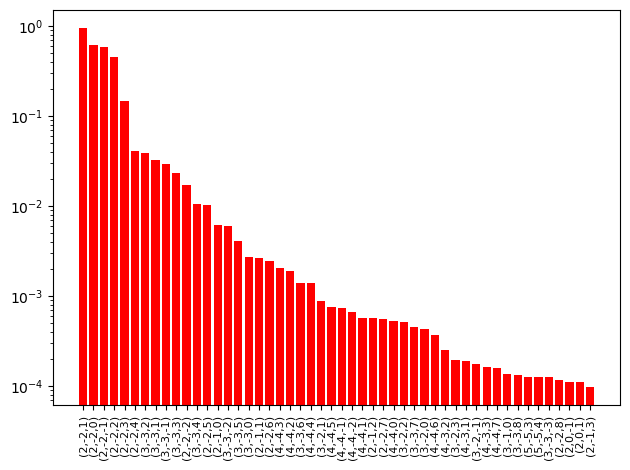

In [34]:

plt.bar(range(len(ma_power)), ma_power, color='red')
plt.xticks(range(len(ma_modes)), ma_modes, rotation=90, fontsize=8)
plt.yscale('log')
plt.tight_layout()
plt.show()